#Improving transfer learning performance for abnormality detection in brain MRI images using feature optimization techniques







##The basic system flow involves the following steps:
1. Data acquisition and pre-processing
2. Feature extraction
3. Feature optimization
4. Classification and Evaluation

PS: It is best to run the code in a Google Colab environment connected to T4 GPU runtime type

## 1. Data acquisition and pre-processing

Here we use the benchmark figshare brain MRI dataset, which can be accessed through the following link : https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5

The figshare dataset contains 3064 MRI images divided into three catagoreis representing the following types of brain tumors: glioma, meningioma and pituitary.

All elements of the dataset are stored in mat files within four folders. For simplicity, we move all the original files into one folder and store it in Google drive before starting pre-processing

In [ ]:
# Import the necessary librares for our work

from google.colab import drive

import numpy as np

import pandas as pd

import os

import h5py

from PIL import Image

import random

import time

from keras.applications.vgg19 import VGG19
from keras.layers import Flatten
from keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.ndimage import gaussian_filter1d
import seaborn as sns


In [ ]:
# Connect to Google Drive to access the dataset
drive.mount('/content/drive')

Mounted at /content/drive


From the original source referred to previously, the data is saved in .mat format , so the first task is to extract the data in the form of images and save them into folders.

In [ ]:
# The path to the folder containing all files in .mat format
inPath ="/content/drive/MyDrive/figshare/dataset_in_mat"

# The path to the folder where the gilioma images will be saved
outPath1 ="/content/drive/MyDrive/figshare/3classes/glioma"

# The path to the folder where the meningioma images will be saved
outPath2 ="/content/drive/MyDrive/figshare/3classes/meningioma"

# The path to the folder where the pituitary images will be saved
outPath3 ="/content/drive/MyDrive/figshare/3classes/pituitary"

for imagePath in os.listdir(inPath):
    # imagePath contains name of the image
    inputPath = os.path.join(inPath, imagePath)
    # Open mat file for reading
    f = h5py.File(inputPath, 'r')
    # Read cjdata struct
    cjdata = f['cjdata']
    # Get image label
    label = cjdata.get('label')[0,0]
    # Get image data and save it as numpy array
    image = np.array(cjdata.get('image')).astype(np.float64)
    # Close mat file
    f.close()

    # Normalize images so that the pixel intensity is within a range from 0 to 255
    hi = np.max(image)
    lo = np.min(image)
    image = (((image - lo)/(hi-lo))*255).astype(np.uint8)
    im = Image.fromarray(image)

    # If the label is equal to 1, the image will be saved in the meningioma folder
    # Saving the image with the jpg extension will ensure that the image is compressed using the jpeg algorithm and thus achieves memory efficiency
    if label == 1.0:
      fullOutPath = os.path.join(outPath2,imagePath)
      fullOutPath = fullOutPath[0:-3] + "jpg"
      im.save(fullOutPath)
    # If the label is equal to 1, the image will be saved in the glioma folder
    elif label==2.0:
      fullOutPath = os.path.join(outPath1,imagePath)
      fullOutPath = fullOutPath[0:-3] + "jpg"
      im.save(fullOutPath)
    # If the label is equal to 1, the image will be saved in the pituitary folder
    elif label==3.0:
      fullOutPath = os.path.join(outPath3,imagePath)
      fullOutPath = fullOutPath[0:-3] + "jpg"
      im.save(fullOutPath)

Now that the data has been converted, we can use it for the task we want to solve.

In [ ]:
# Obtain the path for each meningioma image and store it in a list
meningioma = [os.path.abspath(os.path.join('/content/drive/MyDrive/figshare/3classes/meningioma', p)) for p in os.listdir('/content/drive/MyDrive/figshare/3classes/meningioma')]

In [ ]:
# Obtain the path for each glioma image and store it in a list
glioma = [os.path.abspath(os.path.join('/content/drive/MyDrive/figshare/3classes/glioma', p)) for p in os.listdir('/content/drive/MyDrive/figshare/3classes/glioma')]

In [ ]:
# Obtain the path for each pituitary image and store it in a list
pituitary = [os.path.abspath(os.path.join('/content/drive/MyDrive/figshare/3classes/pituitary', p)) for p in os.listdir('/content/drive/MyDrive/figshare/3classes/pituitary')]

In [ ]:
# Print the number of items in the meningioma list
print(len(meningioma))

708


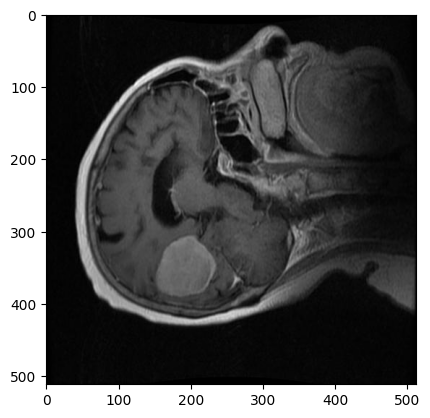

In [ ]:
# Read and display an image from the meningioma folder
img = load_img(meningioma[0])
plt.imshow(img)

In [ ]:
# Print the number of items in the glioma list
print(len(glioma))

1426


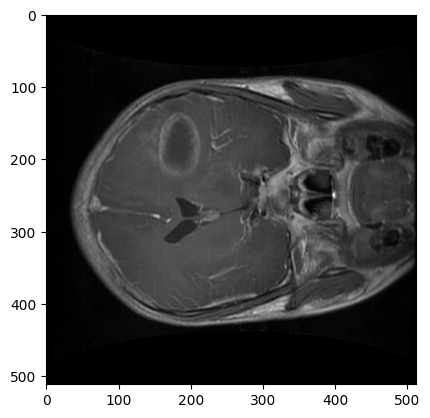

In [ ]:
# Read and display an image from the glioma folder
img = load_img(glioma[0])
plt.imshow(img)

In [ ]:
# Print the number of items in the pituitary list
print(len(pituitary))

930


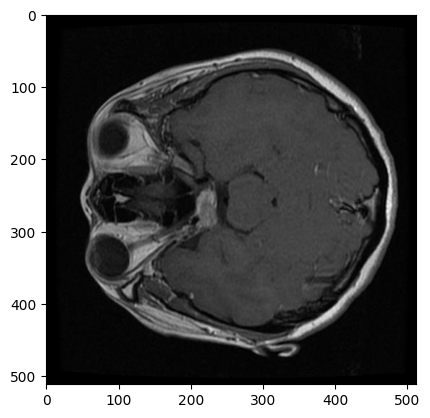

In [ ]:
# Read and display an image from the pituitary folder
img = load_img(pituitary[0])
plt.imshow(img)

## 2. Feature extraction

In this work, we will use the well-known VGG-19 deep model for the feature extraction task.

We fix the model weights that were optimized for the ImageNet dataset and delete the last classification network.

Feeding images forward from the input layer to the last layer will map the input images into a numerical representation that can be used to train machine learning models.

In [ ]:
# Load model without the classifier layer
model = VGG19(include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
# Mark loaded layers as not trainable
for layer in model.layers:
	layer.trainable = False

In [ ]:
# Add a flatten layer to the model
output = Flatten()(model.layers[-1].output)

In [ ]:
# Determine the input layer and output layer of the model
# The input layer is the first layer in the VGG-19 pre-trained model
# The output layer is the added flatten layer
model = Model(inputs=model.inputs, outputs=output)

In [ ]:
# Summarize the structure of the feature extractor
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def get_features(img_path):

    '''
    Parameters
    img_path : Path to the image from which features are to be extracted.
    -----------------------------------------------------------------------------
    Output
    numerical_features : Deep numerical representation of the image.

    '''
    # Read the image from the path
    # The load_img function, by default , converts the original grayscale image to a color image by assigning the value of each\
    # pixel in the grayscale image to each color channel in the color image, then the image is resized to the specified   dimensions
    img = load_img(img_path, target_size=(224, 224, 3))

    # The preprocess_input function converts the image from RGB to BGR and zero-centers it with respect to the imagenet dataset
    # All color channels of thesame pixel have the same value, so converting from RGB to BGR make no difference
    # The zero-centering process with respect to imagenet is performed according to the following formulas\
    # R_centred= R-123.68, G_centred=G-116.779, B_centred= B-103.939
    img_proc = preprocess_input(np.expand_dims(img_to_array(img), axis=0))

    # Extracting features by making prediction using the deep model
    flatten = model.predict(img_proc, verbose=0)

    # Save the extracted features as numpy array of type float16
    numerical_features = np.array(flatten[0]).astype('float16')

    return numerical_features

In [ ]:
# Number of features per image
n = 25088

In [ ]:
# featuresv saves the features extracted from images
# labels stores the class label of each image
featuresv = []
labels = []

In [ ]:
# Iterate through the elements in the glioma image directory to extract features and labels
i=0
for image_path in glioma:

    if i  == 0:
      featuresv = np.reshape(get_features(image_path), (1, n))
      print(featuresv.shape)

    else:
      featuresv = np.append(featuresv,np.reshape(get_features(image_path), (1, n)), axis=0)

    labels.append('glioma')
    i+=1

(1, 25088)


In [ ]:
# Iterate through the elements in the meningioma image directory to extract features and labels
for image_path in meningioma:

    featuresv = np.append(featuresv,np.reshape(get_features(image_path), (1, n)), axis=0)

    labels.append('meningioma')


In [ ]:
# Iterate through the elements in the pituitary image directory to extract features and labels
for image_path in pituitary:

    featuresv = np.append(featuresv,np.reshape(get_features(image_path), (1, n)), axis=0)

    labels.append('pituitary')

In [ ]:
# Print the dimensions of the features matrix
print(featuresv.shape)

(3064, 25088)


In [ ]:
# Print the length of the target matrix
print(len(labels))

3064


## 3. Feature optimization

We use two stages of feature optimization:

1. Reducing the feature space by adjusting the L1-penalty term in the optimization function of the logistic regression algorithm.
2. Mapping the feature space using the RBF similarity kernel so that the number of features becomes equal to the number of samples.

In [ ]:
featuresf = featuresv
labelsf = labels

In [ ]:
# Converting the target variable from categorical form to numerical
labelsf = [int(0) if x=='meningioma' else x for x in labelsf]
labelsf= [int(1) if x=='glioma' else x for x in labelsf]
labelsf= [int(2) if x=='pituitary' else x for x in labelsf]

In [ ]:
# Fixing the value of the random generator to ensure the possibility of reproducing the output
random_state=42
# Allocate 20% of the data for testing and the rest for training
test_size=0.2
# Shuffle the data before spliting
shuffle=True

# Split the dayaset into train and test subsets
X_train, X_test,  y_train, y_test = train_test_split(featuresf, labelsf,  random_state=random_state,   test_size=test_size,   shuffle=shuffle)

Choosing the best regularization parameter value to extract features using L1-penalty logistic regression

In [ ]:
# Adjusting the L1-penalty logistic regression parameters used for features optimization

# Set of regularization parameter values
c = [0.001, 0.01, 0.1, 1, 20, 50, 100, 500, 600, 1000, 2000, 5000]
# Maximum number of iterations taken for the solvers to converge
max_iter=30000
# Add L1-penalty term to the optimization function of the logistic regression
penalty="l1"
# Choose to solve the primal problem
dual=False
# Fixing the value of the random generator to ensure the possibility of reproducing the output
random_state=42
# Using liblinear as a solver in the optimization problem
solver='liblinear'
#######################################################################

# Adjusting the SVM classifer parameters

# Choose the radial basis function as a kernal function for the classifer
kernel='rbf'
# Choose a reasonable value for the classifer regularization parameter
c_svm = 5

#######################################################################

# List num_features is used to save the number of features corresponding to each value of C
num_features = []
# List accuracy is used to save the resulting accuracy corresponding to each value of C
accuracy = []
# List f_score is used to save the resulting F1-score corresponding to each value of C
f_score =[]

# Iterate over C values
for c_val in c:

  # Create an instance of the logistic regression class, adjust its parameter, and then fit it using training samples
  l1_lr = LogisticRegression(max_iter=max_iter, C=c_val, penalty=penalty, dual=dual, random_state=random_state, solver=solver).fit(X_train, y_train)
  # SelectFromModel is a meta-transformer for selecting features based on a specific model, which in our case is logistic regression
  # Settting the prefit parameter to True means that the model used has already been fitted to the data
  feature_reduction = SelectFromModel(l1_lr, prefit=True)
  # Reduce X_train to the selected features
  X_train_transform = feature_reduction.transform(X_train)
  # Reduce X_test to the selected features
  X_test_transform = feature_reduction.transform(X_test)
  # Append the number of resulting features to the num-features list
  num_features.append(X_train_transform.shape[1])

  #####################################################################

  # Create an instance of the SVC class, adjust its parameter
  l1_lr_rbf_svm = SVC(kernel=kernel, C=c_svm, random_state=42)
  # Fit the SVC model according to the given training data
  l1_lr_rbf_svm.fit(X_train_transform, y_train)
  # Perform classification on the test set
  y_predict = l1_lr_rbf_svm.predict(X_test_transform)
  # Append the resulting accuracy to the accuracy list
  accuracy.append(accuracy_score(y_test, y_predict))
  # Append the resulting F1-score to the f_score list
  f_score.append(f1_score(y_test, y_predict, average='macro'))

In [ ]:
# Print the number of features and performance metrics for each value of C
for i in range(0, len(c)):
  print ("For a value of C equal to ", c[i], ", we obtain ", num_features[i], " features, an accuracy of " , accuracy[i], "%, and an f1-score of ", f_score[i], "%.")
  print()

For a value of C equal to  0.001 , we obtain  121  features, an accuracy of  0.9494290375203915 %, and an f1-score of  0.9427663029803975 %.

For a value of C equal to  0.01 , we obtain  665  features, an accuracy of  0.967373572593801 %, and an f1-score of  0.9638222469251566 %.

For a value of C equal to  0.1 , we obtain  1234  features, an accuracy of  0.967373572593801 %, and an f1-score of  0.9639816906749562 %.

For a value of C equal to  1 , we obtain  2365  features, an accuracy of  0.9755301794453507 %, and an f1-score of  0.9722767493955676 %.

For a value of C equal to  20 , we obtain  5031  features, an accuracy of  0.9771615008156607 %, and an f1-score of  0.9744156011881699 %.

For a value of C equal to  50 , we obtain  7181  features, an accuracy of  0.9853181076672104 %, and an f1-score of  0.9833699808523816 %.

For a value of C equal to  100 , we obtain  9215  features, an accuracy of  0.9853181076672104 %, and an f1-score of  0.9833699808523816 %.

For a value of C e

In [ ]:
# Print the C value and the number of features corresponding to the highest accuracy value
max_value = max(accuracy)
max_index = accuracy.index(max_value)
print("The highest accuracy value was ", accuracy[max_index], "%, corresponding to a C value of " , c[max_index], " and a number of features of ", num_features[max_index])

The highest accuracy value was  0.9853181076672104 %, corresponding to a C value of  50  and a number of features of  7181


### Plot the accuracy curve versus the number of features

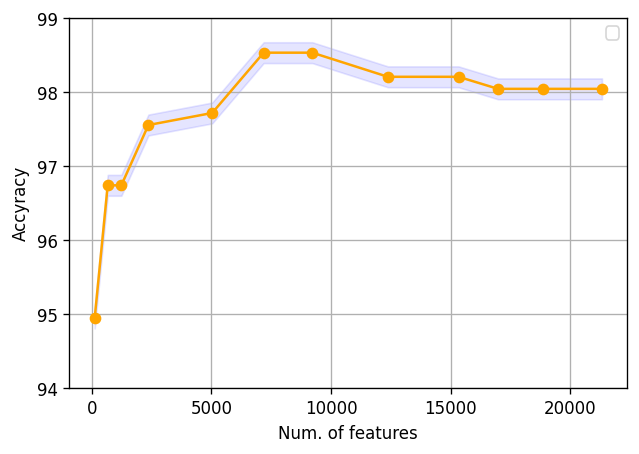

In [ ]:

figure(figsize=(6, 4), dpi=120)

x1 = num_features
y1 = np.array(accuracy)*100

plt.plot(x1, y1,  marker='o', c='orange')

# Define the confidence interval
ci = 14 * np.std(y1) / np.mean(y1)
plt.fill_between(x1, (y1 - ci), (y1 + ci), color = 'blue', alpha = 0.1)

plt.ylabel('Accyracy')
plt.xlabel('Num. of features')
plt.ylim(94,99)
plt.legend()

# Show the plot
plt.grid()
plt.show()

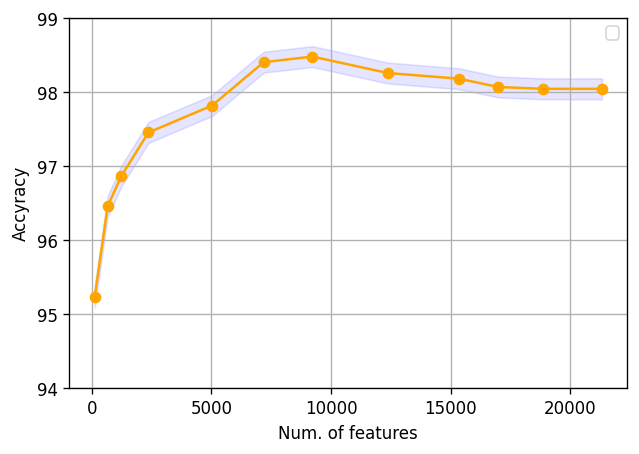

In [ ]:
# Smoothen the curve for better display

figure(figsize=(6, 4), dpi=120)

y1 = gaussian_filter1d(y1, sigma=0.58)


plt.plot(x1, y1, marker='o', c='orange')


plt.fill_between(x1, (y1 - ci), (y1 + ci), color = 'blue', alpha = 0.1)
plt.ylabel('Accyracy')
plt.xlabel('Num. of features')
plt.ylim(94,99)
plt.legend()
# Show the plot
plt.grid()
plt.show()

## 4. Classificarion and evaluation

Using the parameters that produced the best performance to retrain the model.

In [ ]:
l1_lr = LogisticRegression(max_iter=30000, C=50, penalty="l1", dual=False, random_state=42, solver='liblinear').fit(X_train, y_train)
feature_reduction = SelectFromModel(l1_lr, prefit=True)
X_train_transform = feature_reduction.transform(X_train)
X_test_transform = feature_reduction.transform(X_test)
X_train_transform.shape

(2451, 7181)

In [ ]:
l1_lr_rbf_svm = SVC(kernel='rbf', C=5, random_state=42)
l1_lr_rbf_svm.fit(X_train_transform, y_train)
y_predict = l1_lr_rbf_svm.predict(X_test_transform)

In [ ]:
# Display the classificarion report
print(classification_report(y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.9589    0.9790    0.9689       143
           1     1.0000    0.9795    0.9897       293
           2     0.9833    1.0000    0.9916       177

    accuracy                         0.9853       613
   macro avg     0.9807    0.9862    0.9834       613
weighted avg     0.9856    0.9853    0.9854       613



In [ ]:
# Third party function for a fancy drawing of the confusion matrix.

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==20:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                precision,recall,f1_score)
        else:
            #stats_text = "\n\nAccuracy={:0.4f}".format(accuracy)
            pass
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)
sns.set_context('talk')

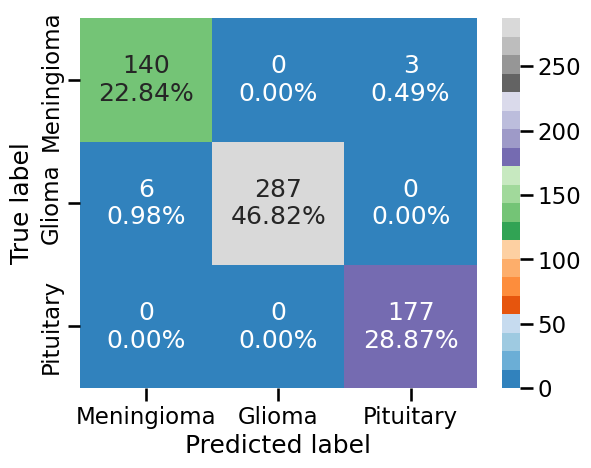

In [ ]:
# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma', 'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='tab20c')

In [ ]:
# Measuring the average inference time for 30 random samples from all classes

random_sample = []

random_sample.extend(random.sample(meningioma, 10))
random_sample.extend(random.sample(glioma, 10))
random_sample.extend(random.sample(pituitary, 10))

start_time = time.time()
for i in random_sample:
  l1_lr_rbf_svm.predict(feature_reduction.transform([get_features(i)]))
print('Average inference time : ', ((time.time() - start_time) / 30), ' S')

Average inference time :  0.0930953582127889  S


________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________